# Imposed Measures in COVID-19
** How Countries are clustering? **

COVID-19, since its outbreak in Wuhan city of China, has spread all over the world. Australia is also affected badly. To control the spread of infection, to save lives and livelihood, different countries 
have imposed different measures. Here we have created a feature vector based on the measures imposed on a country at different point of time with respect to the first case recorded. Our focus is on 
the countries that have the number of confirmed cases more than Australia. We have then used K-means
clustering to group the countries, and analysed the measures that played significant roles in forming
these clusters.


In [26]:
# All datasets are sourced from https://data.humdata.org/dataset/novel-coronavirus-2019-ncov-cases
# The followings are libraries/packages needed for data analysis and plotting
# Seaborn is based on Matplotlib and used to enhance the visualisation

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt 
import matplotlib.cm as cm
import seaborn as sb
from adjustText import adjust_text # use "conda install -c primer adjusttext" from Ananconda prompt
import re # for regular expressions
%matplotlib inline

## ************************** Confirmed cases  *******************************
url_confirmed = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/\
csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
df_confirmed = pd.read_csv(url_confirmed, index_col="Country/Region")
df_confirmed.drop(['Lat', 'Long'], axis=1, inplace=True) # We are not interested in these two columns

# K-means clustering is sensitive to data. With time the number of countries having
# number of cases more than Australia is growing, and thus affecting the clustering.
# To compare with the results with 12thJun scenario we need to discard data after 12thJune.
# That's why I am deleting last few columns after 12thJune). 
# Discard the following 3 lines if one wants to work with the latest data then
cols_del = len(df_confirmed.columns) - ((df_confirmed.columns).get_loc('6/12/20'))-1
print(len(df_confirmed.columns), (df_confirmed.columns).get_loc('6/12/20'), cols_del)
df_confirmed.drop(df_confirmed.columns[-cols_del:], axis=1, inplace=True) 

# Data for Australian states 
Aust_confirmed = df_confirmed.loc["Australia"]
for i in range(len(Aust_confirmed)):  
      Aust_confirmed.index.values[i]= "Australia_"+ Aust_confirmed.iloc[i]['Province/State']
del Aust_confirmed["Province/State"]   

# Country grouping on original dataframe        
gr_confirmed = df_confirmed.groupby("Country/Region").sum()

# # Now adding Australian dataframe (this is to keep entry for Australia's total as well as state data)
gr_confirmed = pd.concat([gr_confirmed, Aust_confirmed])

# Adding data for China (1-Jan to 20-Jan from a China CDC publication)
lab=[]
for i in range(1,22):
    lab.append("1/" + str(i) + "/20")
    gr_confirmed.insert(i-1,lab[i-1],0)
gr_confirmed.loc["China"][0:10] = 20
gr_confirmed.loc["China"][10:21] = 310

# Remove Diamond princess as we do not want to include that data for our analysis
gr_confirmed = gr_confirmed.drop("Diamond Princess")

#Dates are converted into no of days since 1/1/20 so that 1/1/20 corresponds to day 1
dates = gr_confirmed.keys()
date_1st_case = gr_confirmed.ne(0).idxmax(axis=1) # x gives position of first non-zero value in each row
FMT = '%m/%d/%y'
days = dates.map(lambda x: (datetime.strptime(x, FMT) - datetime.strptime("1/1/20", FMT)).days) 
gr_confirmed.columns = days
x = gr_confirmed.ne(0).idxmax(axis=1) # x gives position of first non-zero value in each row
x_aust = gr_confirmed.loc["Australia"].ne(0).idxmax(axis=1) #x_aust: position of 1st case for Aust

# Subset of countries having cases reported earlier than Australia (i.e cases reported before 26Jan) 
gr_confirmed_sub = pd.DataFrame(columns= days)
for i in range(len(gr_confirmed.index)):
    if (x[i] <= x_aust) and (gr_confirmed.iloc[i].max() != 0) and\
        not(re.search('Australia_', gr_confirmed.index[i])):
       gr_confirmed_sub = gr_confirmed_sub.append(gr_confirmed.loc[gr_confirmed.index[i]]) 
   
x_sub = gr_confirmed_sub.ne(0).idxmax(axis=1) # x_sub gives position of first non-zero value in each row
for i in range(gr_confirmed_sub.shape[0]):
    gr_confirmed_sub.iloc[i] = gr_confirmed_sub.iloc[i].shift(periods=-x_sub[i]) # data starts from day when a first case is reported
gr_confirmed_sub.columns = dates

# ******** Subset of countries having no. of cases more than Australia **********
max_aust = gr_confirmed.loc["Australia"].max()
gr_confirmed_sub1 = pd.DataFrame(columns= days)
for i in range(len(gr_confirmed.index)):
    if gr_confirmed.iloc[i].max() >= max_aust:
       gr_confirmed_sub1 = gr_confirmed_sub1.append(gr_confirmed.loc[gr_confirmed.index[i]]) 
#gr_confirmed_sub1_max = gr_confirmed_sub1.copy()   

x_sub1 = gr_confirmed_sub1.ne(0).idxmax(axis=1) # x_sub1 gives position of first non-zero value in each row
for i in range(gr_confirmed_sub1.shape[0]):
    gr_confirmed_sub1.iloc[i] = gr_confirmed_sub1.iloc[i].shift(periods=-x_sub1[i]) # data starts from day when a first case is reported
gr_confirmed_sub1.columns = dates

for i in range(gr_confirmed.shape[0]):
    gr_confirmed.iloc[i] = gr_confirmed.iloc[i].shift(periods=-x[i]) # all data shift to one starting point 
gr_confirmed.columns = dates



172 143 28


In [27]:
df_confirmed.head()

,Province/State,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,...,6/3/20,6/4/20,6/5/20,6/6/20,6/7/20,6/8/20,6/9/20,6/10/20,6/11/20,6/12/20
Country/Region,,,,,,,,,,,,,,,,,,,,,
Afghanistan,NaN,0,0,0,0,0,0,0,0,0,...,17267,18054,18969,19551,20342,20917,21459,22142,22890,23546
Albania,NaN,0,0,0,0,0,0,0,0,0,...,1184,1197,1212,1232,1246,1263,1299,1341,1385,1416
Algeria,NaN,0,0,0,0,0,0,0,0,0,...,9733,9831,9935,10050,10154,10265,10382,10484,10589,10698
Andorra,NaN,0,0,0,0,0,0,0,0,0,...,851,852,852,852,852,852,852,852,852,853
Angola,NaN,0,0,0,0,0,0,0,0,0,...,86,86,86,88,91,92,96,113,118,130


In [28]:
gr_confirmed.head()

,1/1/20,1/2/20,1/3/20,1/4/20,1/5/20,1/6/20,1/7/20,1/8/20,1/9/20,1/10/20,...,6/3/20,6/4/20,6/5/20,6/6/20,6/7/20,6/8/20,6/9/20,6/10/20,6/11/20,6/12/20
Country/Region,,,,,,,,,,,,,,,,,,,,,
Afghanistan,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Albania,2.00,10.00,12.00,23.00,33.00,38.00,42.00,51.00,55.00,59.00,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Algeria,1.00,1.00,1.00,1.00,1.00,1.00,3.00,5.00,12.00,12.00,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Andorra,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Angola,1.00,2.00,2.00,3.00,3.00,3.00,4.00,4.00,5.00,7.00,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


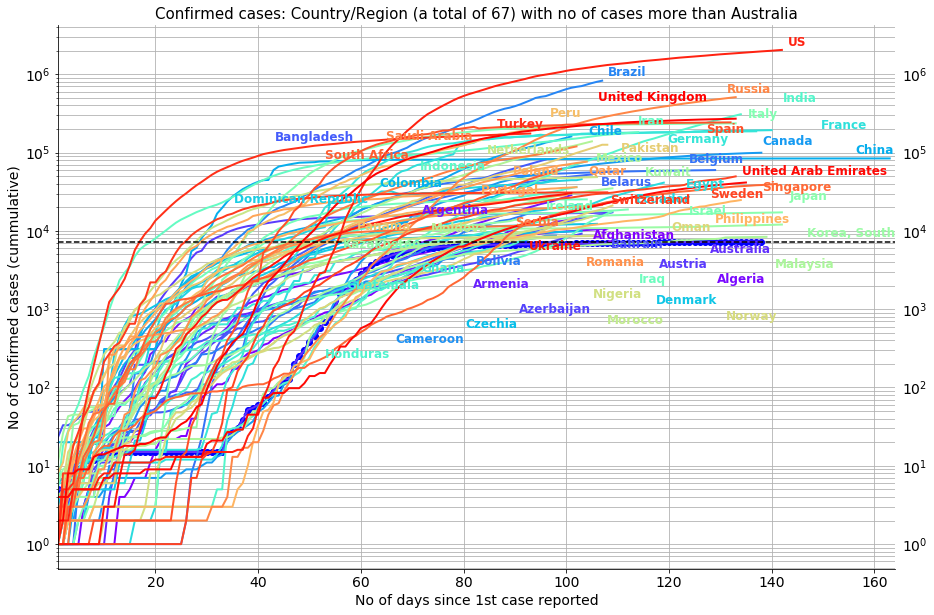

In [29]:
# ## Visualising time series data for sub dataframe - no of cases more than Australia

no_plots = len(gr_confirmed_sub1.index)
colors = cm.rainbow(np.linspace(0, 1, no_plots ))

plt.figure(figsize=(15,10))
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')

plt.title("Confirmed cases: Country/Region (a total of %i) with no of cases more than Australia"%(no_plots-1), fontsize=15, )
plt.xlabel("No of days since 1st case reported", fontsize=14)
plt.ylabel("No of confirmed cases (cummulative)", fontsize=14)

xpos = []
ypos = []
for i, color in enumerate(colors, start=0):
    if ( gr_confirmed_sub1.iloc[i].tail(1).isnull().bool() == True):
       idx = pd.isnull(gr_confirmed_sub1.iloc[i]).to_numpy().nonzero()[0]
       xpos.append(idx[0]) 
       ypos.append(gr_confirmed_sub1.iloc[i][idx[0]-1]) 
    else:   
       xpos.append(len(gr_confirmed_sub1.iloc[i]))
       ypos.append(gr_confirmed_sub1.iloc[i][len(gr_confirmed_sub1.iloc[i])-1])
    if gr_confirmed_sub1.index[i] == "Australia":
       plt.plot(days, gr_confirmed_sub1.iloc[i], "--bo", linewidth=3) 
    plt.plot(days, gr_confirmed_sub1.iloc[i], "-", color=color, linewidth=2)
plt.yscale("log") # put this before the texts position else may throw error as ypos can exceed the limit
texts = [plt.text(xpos[i], ypos[i], gr_confirmed_sub1.index[i], color=colors[i], fontsize=12,\
                  alpha=1,fontweight='bold') for i in range(no_plots)]
adjust_text(texts)
plt.axhline(gr_confirmed_sub.loc["Australia"].max(), color ='black', linestyle='--')
plt.yscale("log")
plt.tick_params(labelright=True, labelsize=14)
plt.grid(which="both")
plt.xlim(1,len(days))

plt.savefig('C:/Users/das_g/Desktop/Gitua/COVID-19/Plot_Aust_confirmed_sub1.jpg')
plt.show()

# # # Writing the dataframes into a csv file
# gr_confirmed_sub1.to_csv("C:/Users/das_g/Desktop/Gitua/COVID-19/gr_confirmed_sub1.csv")

# # Plot confirmed cases for top 10 countries with plotly (interactive)
# import plotly.graph_objects as go # plotly express may need to install plotly

# # First get top 10 countries in terms of number of confirmed cases
# top_10 = df_confirmed.sort_values(df_confirmed.columns[-1], ascending=False).iloc[:10]
# gr_confirmed.columns = days
# fig = go.Figure()
# for i in top_10.index:
#     fig.add_trace(go.Scatter(x=gr_confirmed.columns,
#                              y=gr_confirmed.loc[i],
#                              name=i
#                              ))
# fig.update_yaxes(type="log") # use log scale 
# fig.update_layout(
#         title={
#         'text': "Confirmed cases: top 10 countries in the world",
#         'y':0.9,
#         'x':0.5,
#         'xanchor': 'center',
#         'yanchor': 'top'},    
#     xaxis=dict(
#         title='No of days since 1st case reported',
#         titlefont_size=16,
#         tickfont_size=14,
#     ),
#     yaxis=dict(
#         title='No of confirmed cases (cummulative)',
#         titlefont_size=16,
#         tickfont_size=14,
#     ),
#     legend=dict(
#         x=0,
#         y=1.0,
#         bgcolor='rgba(255, 255, 255, 0)',
#         bordercolor='rgba(255, 255, 255, 0)'
#     )
# )
# fig.show()
# #fig.write_image("C:/Users/das_g/Desktop/Gitua/COVID-19/top_10.jpeg") # need "conda install -c plotly plotly-orca"
# fig.write_html("C:/Users/das_g/Desktop/Gitua/COVID-19/top_10.html")


In [30]:
## The following dataset is sourced from https://data.humdata.org/dataset that contains 
## measures imposed by government to control spread of infection 

#url_measure = "http://data.humdata.org/dataset/e1a91ae0-292d-4434-bc75-bf863d4608ba/resource/c3710749-f552-455d-a9ec-5d9fe974be75/download/acaps_covid19_government_measures_dataset.xlsx"
measure_df = pd.read_excel("C:/Users/das_g/Desktop/Gitua/COVID-19/acaps_covid19_government_measures_dataset.xlsx", sheet_name="Database", index_col="COUNTRY")
#measure_df = pd.read_excel(url_measure, sheet_name = "Database", index_col="COUNTRY")
measure_df.head()
measure_df = measure_df[["MEASURE","DATE_IMPLEMENTED"]]
measure_df = measure_df[pd.notnull(measure_df["DATE_IMPLEMENTED"])]

# # The following names are changed according to those as recorded in confirmed data  
measure_df.index = measure_df.index.str.replace("United States of America", "US") 
measure_df.index = measure_df.index.str.replace("Korea Republic of", "Korea, South")
measure_df.index = measure_df.index.str.replace("kenya", "Kenya")

## Create a dictionary x that contains pairs of country & corresponding list of measures
## We consider only those countries having confirmed cases more than Australia. Thus the 
## dataframe gr_confirmed_sub1 as obtained before is used and having measure data is available

x = {}
measure_list = []
country_list = [i for i in gr_confirmed_sub1.index if i in measure_df.index ]

for i in range(len(country_list)):
    y = measure_df.loc[country_list[i], "MEASURE"]    
    
    if isinstance(y, str) != True:        
        y = y.unique()
        y = [y[i].rstrip() for i in range(len(y)) ]        
        x[country_list[i]] = y            
    else:
        x[country_list[i]] = y
        
## Create a set consisting of all the measures taken by countries; so any country's set will be a subset of that unique set 
measure_set = set()
for i in range(len(country_list)-1):
    measure_set.update(set(x[country_list[i]]).union(set(x[country_list[i+1]])))   
measure_set = [item for item in measure_set if len(item) > 1] # removes unwanted single-character elements from set
measure_list = list(measure_set)

## The following finds the number of days a measure has been imposed wrt to the date of first case for that country
days_dict = {}
days_no = {}
for j in range(len(country_list)): 
#gives the first ones as several dates are recorded for one measure
    if isinstance(x[country_list[j]], str) == False :
        a = measure_df.loc[country_list[j]].drop_duplicates(subset="MEASURE", keep='first')
        a["MEASURE"] = a["MEASURE"].str.rstrip()
        days_no = {a.iloc[i]['MEASURE']: ((a.iloc[i]['DATE_IMPLEMENTED']).strftime(FMT)) for i in range(len(x[country_list[j]]))}
        days_dict[country_list[j]] = days_no
 
for c_id, c_info in days_dict.items():
    for key in c_info:         
        #c_info[key] = (datetime.strptime(c_info[key], FMT) - datetime.strptime('1/1/20', FMT)).days
        c_info[key] = (datetime.strptime(c_info[key], FMT) - datetime.strptime(date_1st_case[c_id], FMT)).days
        #print(c_id, c_info[key])

new_days_dict = {}
new_data = []
## If any measure is absent i.e not used for a country we set a value of nan
for j in range(len(country_list)):
    new_days = {}    
    for i in measure_list:        
        if i not in days_dict[country_list[j]]:
            new_days[i] = np.nan  
            new_data.append(np.nan)          
        else:            
            new_days[i] = days_dict[country_list[j]][i]
            new_data.append(days_dict[country_list[j]][i])           
    new_days_dict[country_list[j]] = new_days
   
idx = pd.MultiIndex.from_product([country_list, measure_list])
measures_days = pd.DataFrame(data=new_data, index=idx, columns=['Measures Days'])
idx.set_names(['Country', 'Measures'], inplace=True) 
measures_days = measures_days.reset_index()
measures_days = measures_days.pivot(index="Country", columns="Measures", values= "Measures Days")
## Duplication in measures - starting letter is both uppercase and small case
measures_days.drop(["curfews", "testing policy", "limit public gatherings",\
                    "strengthening the public health system", "awareness campaigns",\
                    "full lockdown"], axis=1, inplace=True)           
#measures_days.to_csv("C:/Users/das_g/Desktop/Gitua/COVID-19/measures_days.csv")

## If a measure is imposed on the same day then its value will be 1, and if on days.max() 
## (i.e today's date) then 0. Basically the earlier a measure is imposed the higher is the value
## All absent/missing values with nan are now replaced by a very small no (close to 0)
measures_days = measures_days.apply(lambda x: (days.max() - x) / days.max())
measures_days = measures_days.replace(np.nan, 0.00001)
#measures_days = measures_days.replace(np.nan, days.max())
#measures_days.to_csv("C:/Users/das_g/Desktop/Gitua/COVID-19/measures_days.csv", mode='a', header=False)

In [31]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
measures_days

Measures,Additional health/documents requirements upon arrival,Amendments to funeral and burial regulations,Awareness campaigns,Border checks,Border closure,Changes in prison-related policies,Checkpoints within the country,Closure of businesses and public services,Curfews,Domestic travel restrictions,Economic measures,Emergency administrative structures activated or established,Full lockdown,General recommendations,Health screenings in airports and border crossings,Humanitarian exemptions,International flights suspension,Isolation and quarantine policies,Limit product imports/exports,Limit public gatherings,Lockdown of refugee/idp camps or other minorities,Mass population testing,Military deployment,Other public health measures enforced,Partial lockdown,Psychological assistance and medical social work,Requirement to wear protective gear in public,Schools closure,State of emergency declared,Strengthening the public health system,Surveillance and monitoring,Testing policy,Visa restrictions
Country,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0.00,0.00,1.07,1.14,1.00,0.78,0.00,0.00,0.00,1.00,0.00,1.07,0.00,1.00,1.07,0.00,1.17,1.07,0.96,0.90,0.00,0.00,0.00,1.02,0.80,0.00,0.00,0.96,1.00,0.96,1.07,0.00,0.00
Algeria,0.00,0.00,0.94,0.90,0.87,0.00,0.83,0.85,0.83,0.84,0.00,0.00,0.83,0.00,0.00,0.00,0.85,0.87,0.00,0.90,0.00,0.00,0.83,0.00,0.75,0.00,0.56,0.90,0.00,0.00,0.00,0.00,0.00
Argentina,0.00,0.00,1.09,0.00,0.86,0.00,0.00,0.92,0.00,0.90,0.92,0.00,0.00,0.83,0.00,0.00,0.94,0.94,0.00,0.94,0.00,0.61,0.00,0.00,0.90,0.00,0.83,0.92,0.90,0.91,0.87,0.68,0.95
Armenia,0.00,0.00,1.18,0.00,1.04,0.00,0.67,0.72,0.00,0.86,0.82,0.00,0.00,0.00,0.94,0.00,0.87,0.93,0.00,0.91,0.00,0.00,0.00,0.00,0.86,0.00,0.52,0.99,0.91,0.00,0.00,0.00,0.94
Australia,0.00,0.00,0.69,0.00,0.67,0.67,0.00,0.66,0.00,0.66,0.79,0.87,0.00,0.66,0.00,0.00,0.64,0.79,0.00,0.71,0.00,0.00,0.52,0.44,0.61,0.64,0.00,0.66,0.53,0.72,0.62,0.64,0.79
Austria,0.82,0.56,0.81,0.91,0.91,0.00,0.00,0.88,0.00,0.90,0.89,0.86,0.00,0.66,0.00,0.00,0.91,0.87,0.00,0.88,0.64,0.00,0.58,0.79,0.88,0.87,0.79,0.88,0.00,0.85,0.69,0.74,0.88
Azerbaijan,0.00,0.00,0.95,0.00,1.01,0.78,0.00,0.63,0.00,0.00,0.89,0.75,0.86,0.00,1.00,0.00,0.00,1.00,0.00,0.92,0.00,0.00,0.00,0.00,0.92,0.00,0.58,1.00,0.00,0.77,0.00,0.00,1.00
Bahrain,0.00,0.00,0.61,0.00,0.93,0.90,0.00,0.88,0.81,0.00,0.71,0.00,0.00,0.00,0.96,0.00,0.86,0.96,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.72,0.99,0.00,0.69,0.75,0.74,0.96
Bangladesh,1.04,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.80,0.60,0.63,0.87,0.00,0.00,1.00,0.00,0.95,1.00,0.00,0.00,0.00,0.00,0.87,0.00,0.87,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.95


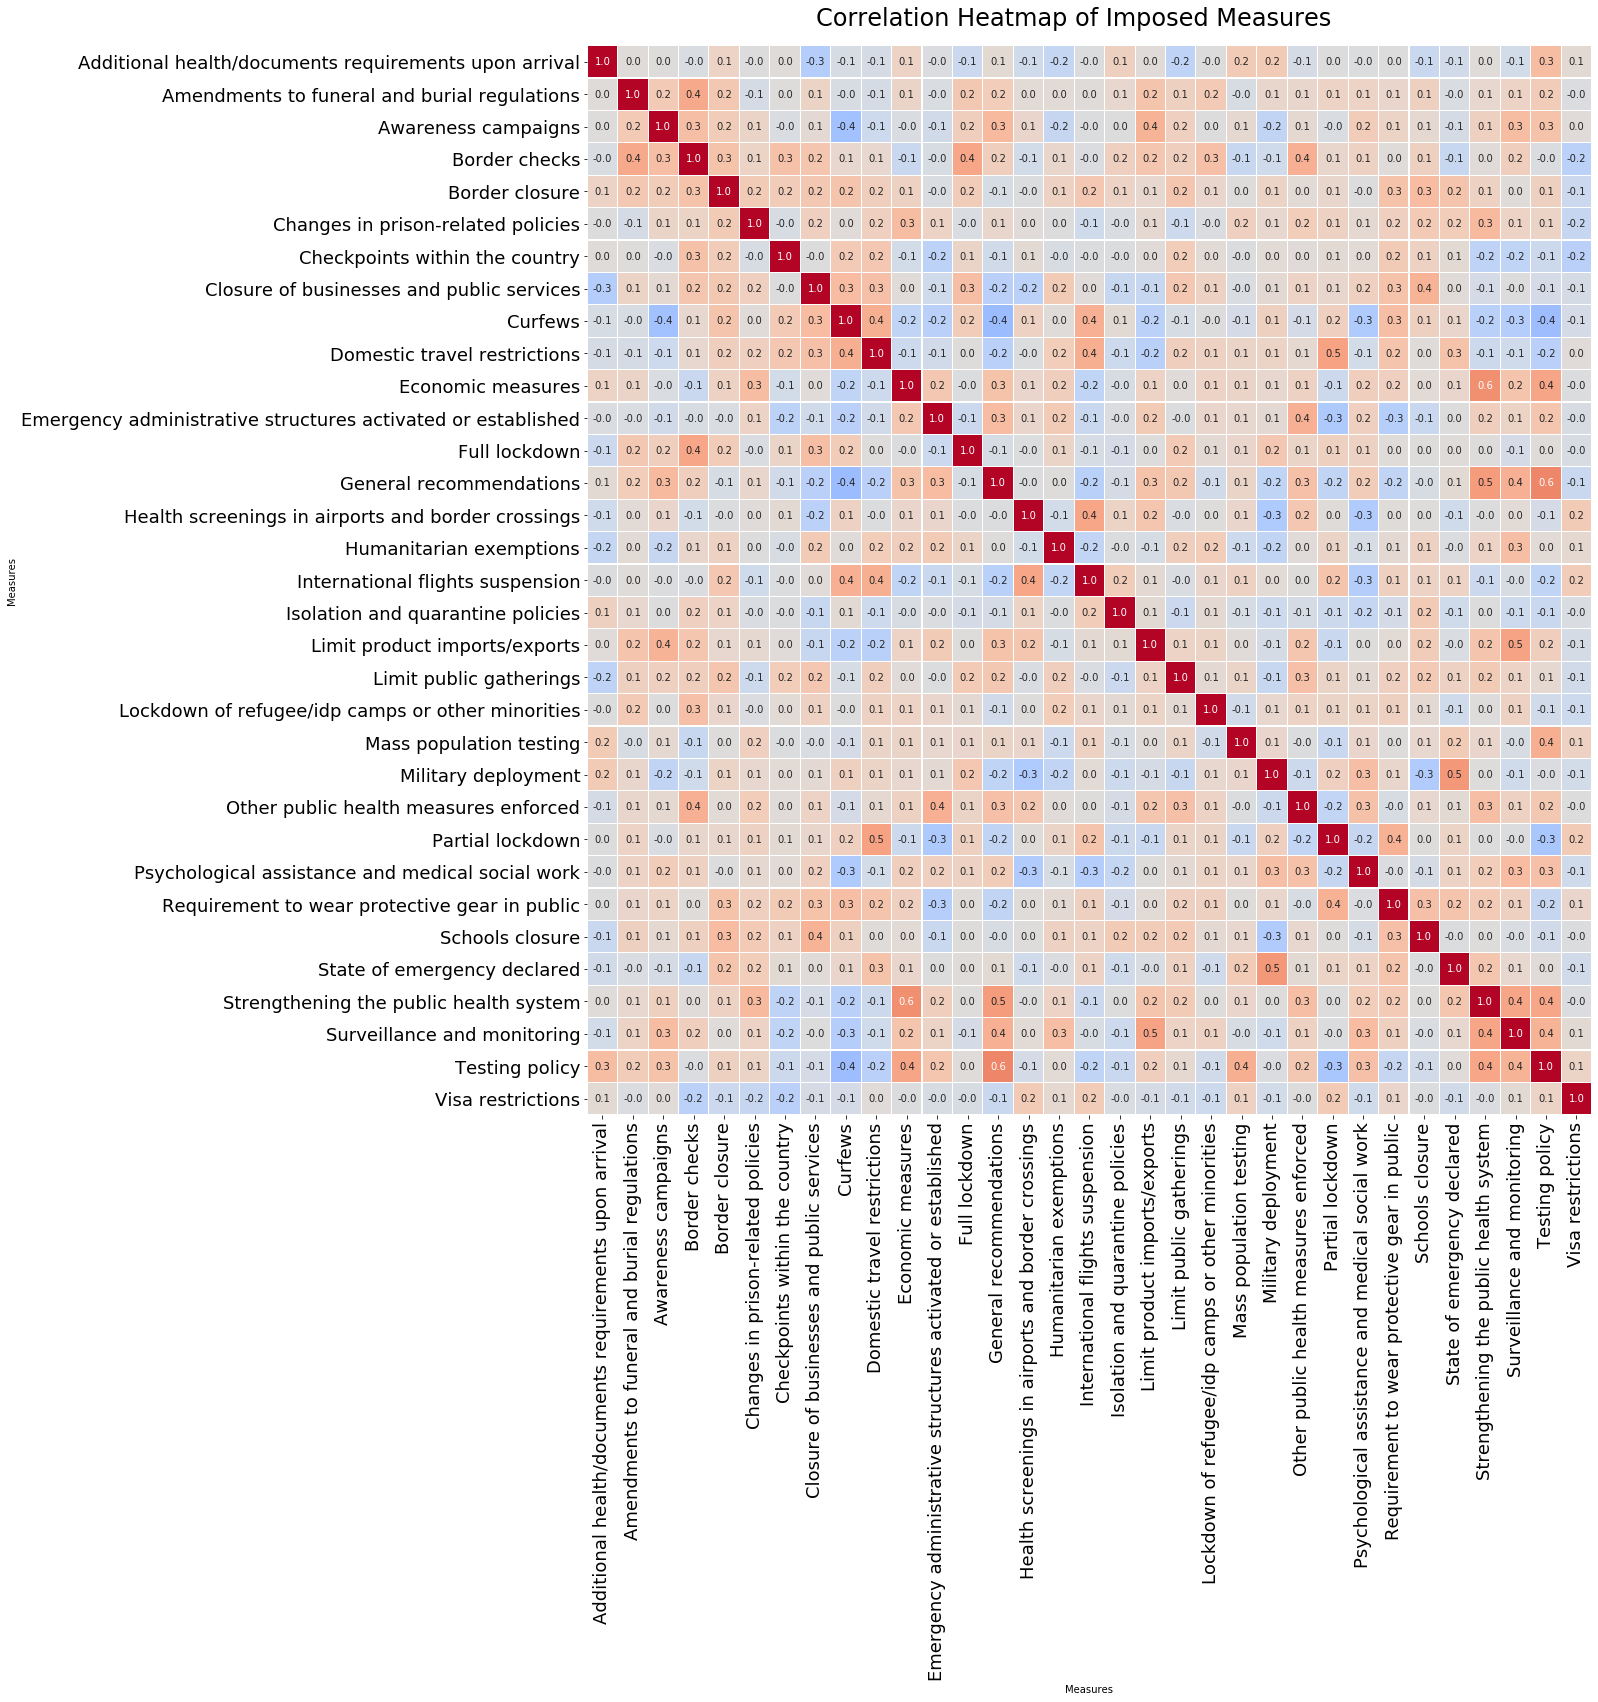

In [32]:
# Correlation matrix heatmap for measures_days data
data = measures_days
corr = data.corr(method='pearson') #default

fig = plt.figure(figsize=(18,18))
hm = sb.heatmap(corr.round(2), 
            annot=True, linewidth=0.05, vmin=-1, vmax=1, center=0, cmap='coolwarm', fmt='.1f', cbar=False)
hm.set_xticklabels(hm.get_xmajorticklabels(), fontsize = 18)
hm.set_yticklabels(hm.get_ymajorticklabels(), fontsize = 18)
fig.suptitle('Correlation Heatmap of Imposed Measures', fontsize=24)
fig.subplots_adjust(top=0.95)
figure = hm.get_figure()    
figure.savefig('C:/Users/das_g/Desktop/Gitua/COVID-19/Vals_corr.jpg', bbox_inches='tight')

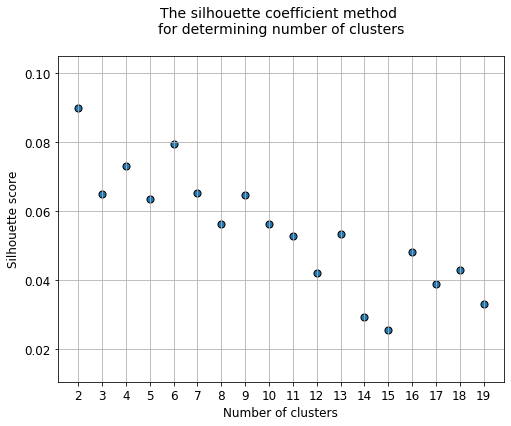

Cluster - 1
['Australia', 'Austria', 'Belgium', 'Denmark', 'France', 'Germany', 'Italy', 'Kazakhstan', 'Norway', 'Philippines', 'Portugal', 'South Africa', 'Spain', 'Switzerland']
Cluster - 2
['Guatemala', 'Ireland', 'Israel', 'Panama']
Cluster - 3
['Bangladesh', 'Belarus', 'Cameroon', 'Canada', 'China', 'Dominican Republic', 'Egypt', 'Ghana', 'India', 'Indonesia', 'Japan', 'Korea, South', 'Malaysia', 'Netherlands', 'Nigeria', 'Sweden', 'US', 'United Kingdom']
Cluster - 4
['Algeria', 'Argentina', 'Armenia', 'Azerbaijan', 'Bahrain', 'Brazil', 'Honduras', 'Iraq', 'Kuwait', 'Oman', 'Qatar', 'Saudi Arabia', 'Serbia', 'Turkey', 'United Arab Emirates']
Cluster - 5
['Bolivia', 'Chile', 'Colombia', 'Ecuador', 'Mexico', 'Peru', 'Romania']
Cluster - 6
['Afghanistan', 'Iran', 'Morocco', 'Pakistan', 'Poland', 'Singapore', 'Ukraine']


In [33]:
## Using K-means clustering to find the number of clusters in our dataset (measures_days).
## In our case measures_days.shape[0] is the no of samples and 
## measures_days.shape[1] (i.e no of measures) is the no of features

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import preprocessing 
from collections import defaultdict 
from sklearn.metrics import silhouette_score

### ********** scaled & reduced data ###################
scaled_data = preprocessing.StandardScaler().fit_transform(measures_days) # mean =0 & std=1
pca = PCA(n_components=0.98) # 98% variance in feature dimension is retained
pca.fit(scaled_data)
reduced_data = pca.transform(scaled_data)

# Plotting the Cumulative Summation of the Explained Variance. This helps to choose the no of components to be 
# used in PCA that provides high variance in data
# pca.explained_variance_ratio_.cumsum() gives the variance that we want to consider. In our case 25 
# components is required. The same can be easily done with the use of n_components=0.99 in PCA & the dim
# of reduced_data is 25.

# features=range(pca.n_components)
# plt.figure(figsize=(15,10))
# #plt.plot(pca.explained_variance_ratio_)
# plt.bar(features, pca.explained_variance_ratio_)
# plt.xlabel('PCA Components')
# plt.ylabel('Percentage of Explained Variance') #for each component
# plt.title('Scree Plot')
# plt.show()

km_scores= []
km_silhouette = []
N = 20
for i in range(2,N):
    km = KMeans(n_clusters=i, init='random',\
                n_init=10, max_iter=300, tol=1e-04, random_state=10).fit(reduced_data)
    preds = km.predict(reduced_data)  
    silhouette = silhouette_score(reduced_data,preds)
    km_silhouette.append(silhouette)    
plt.figure(figsize=(8,6))
plt.title("The silhouette coefficient method \nfor determining number of clusters\n",fontsize=14)
plt.scatter(x=[i for i in range(2,N)],y=km_silhouette,s=50,edgecolor='k')
plt.grid(True)
plt.xlabel("Number of clusters",fontsize=12)
plt.ylabel("Silhouette score",fontsize=12)
plt.xticks([i for i in range(2,N)],fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('C:/Users/das_g/Desktop/Gitua/COVID-19/Shilhouette.jpg', bbox='tight')
plt.show()

## In the following code the value of n_clusters is obtained from the Silhoutte score as above

km = KMeans(n_clusters=6, init='random', n_init=10, max_iter=300, tol=1e-04, random_state=10)
y_km = km.fit_predict(reduced_data) # cluster labels of all data points (here countries)

cluster_dict = {}
for i in range(len(y_km)):
    cluster_dict[measures_days.index[i]] = y_km[i]
          
res = defaultdict(list) 
for key, val in sorted(cluster_dict.items()): 
    res[val].append(key)    

for i in res:
    if "Australia" in res[i]:
        cluster_of_australia = res[i]
for i in range(len(res)):
    print("Cluster - %i" %(i+1))
    print(res[i])


Australia 64 383 6.0 138 98.0
Austria 32 780 32.0 108 96.0
Belgium 71 1453 130.0 129 91.0
Denmark 41 330 32.0 106 90.0
France 83 8387 462.0 140 94.0
Germany 66 5837 329.0 137 94.0
Italy 55 5651 253.0 133 96.0
Kazakhstan 82 395 223.0 91 44.0
Norway 32 271 14.0 107 95.0
Philippines 126 685 594.0 134 13.0
Portugal 32 803 316.0 102 61.0
South Africa 99 2642 2642.0 99 0.0
Spain 59 8005 319.0 132 96.0
Switzerland 29 1124 18.0 108 98.0


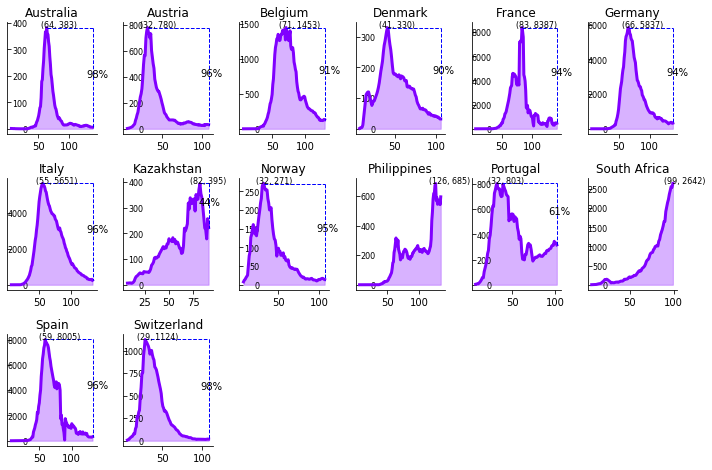

Guatemala 90 357 357.0 90 0.0
Ireland 47 957 12.0 104 99.0
Israel 42 628 176.0 112 72.0
Panama 94 535 535.0 94 0.0


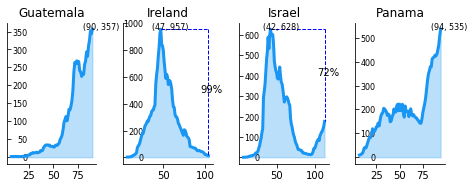

Bangladesh 96 3019 3019.0 96 0.0
Belarus 79 954 807.0 105 15.0
Cameroon 96 299 184.0 98 39.0
Canada 87 1922 521.0 138 73.0
China 44 4607 7.0 163 100.0
Dominican Republic 103 471 471.0 103 0.0
Egypt 119 1455 1455.0 119 0.0
Ghana 61 348 241.0 90 31.0
India 134 10401 10401.0 134 0.0
Indonesia 102 984 984.0 102 0.0
Japan 84 545 42.0 142 92.0
Korea, South 42 623 47.0 142 92.0
Malaysia 74 173 19.0 139 89.0
Netherlands 47 1124 187.0 106 83.0
Nigeria 105 477 477.0 105 0.0
Sweden 130 1048 964.0 133 8.0
US 79 31628 20726.0 142 34.0
United Kingdom 82 4868 1002.0 133 79.0


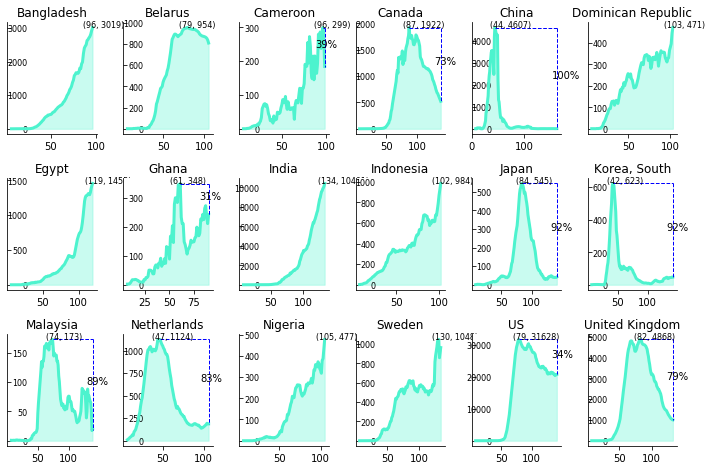

Algeria 91 189 109.0 108 42.0
Argentina 101 1104 1104.0 101 0.0
Armenia 98 550 495.0 103 10.0
Azerbaijan 102 337 337.0 103 0.0
Bahrain 103 513 491.0 109 4.0
Brazil 105 26914 26148.0 107 3.0
Honduras 93 309 309.0 93 0.0
Iraq 109 1132 1132.0 109 0.0
Kuwait 88 958 615.0 109 36.0
Oman 109 855 855.0 109 0.0
Qatar 95 1888 1585.0 104 16.0
Saudi Arabia 102 3456 3456.0 102 0.0
Serbia 44 384 73.0 98 81.0
Turkey 36 4559 983.0 93 78.0
United Arab Emirates 116 875 551.0 135 37.0


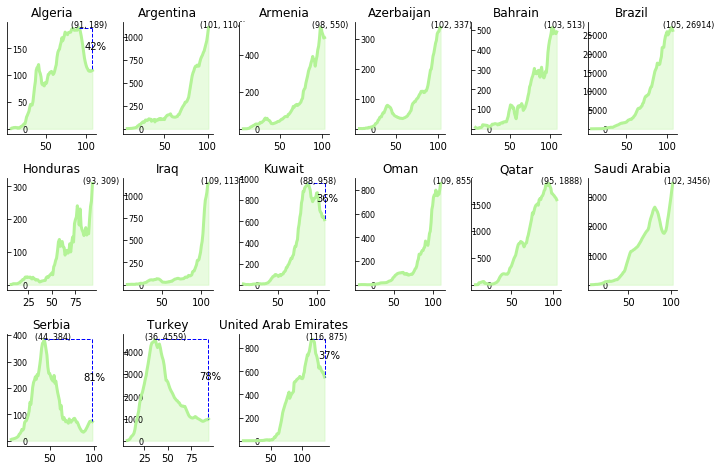

Bolivia 93 600 600.0 93 0.0
Chile 101 5478 5478.0 101 0.0
Colombia 94 1638 1226.0 98 25.0
Ecuador 54 2038 600.0 103 71.0
Mexico 105 4167 4167.0 105 0.0
Peru 87 6580 3913.0 98 41.0
Romania 51 371 186.0 107 50.0


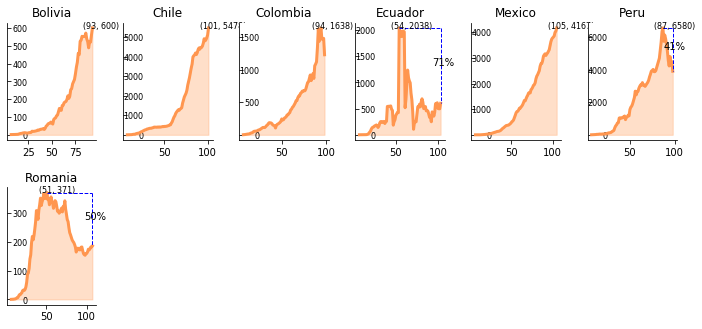

Afghanistan 102 759 654.0 109 14.0
Iran 43 3009 2196.0 114 27.0
Morocco 51 203 77.0 102 62.0
Pakistan 107 5241 4564.0 108 13.0
Poland 100 452 452.0 100 0.0
Singapore 94 1005 381.0 141 62.0
Ukraine 96 561 553.0 101 1.0


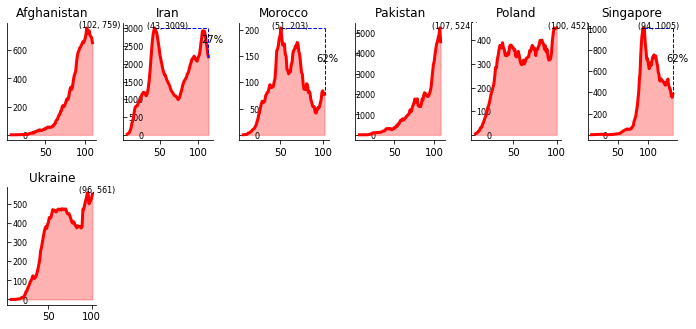

In [34]:
# # Plots of flattening curve for all clusters- 7-day rolling average of daily confirmed cases

# gr_confirmed_sub1_daily = gr_confirmed_sub1.diff(axis=1) # obtain from cummulative data
# daily = gr_confirmed_sub1_daily.copy()
# daily.loc["Ecuador"] = daily.loc["Ecuador"].clip(lower=0)
# daily_rolling = daily.rolling(window=7, axis=1).mean()
# daily_rolling.columns = days

# # Find the positions and values of max cases and those at today. Also, the rate of percentage decrease
# # from peak value

# country_vals = defaultdict(list) 
# for i in range(len(res)):
#     for country in res[i]:
#         val_today = daily_rolling.loc[country].mask(daily_rolling.loc[country]==0).ffill().iloc[-1]
#         #daily_rolling.loc[country].notna().idxmax() # first valid index
#         pos_today = daily_rolling.loc[country].notna()[::-1].idxmax() # last valid index (after that all nan)
#         val_max = daily_rolling.loc[country].max()
#         pos_max = daily_rolling.loc[country].idxmax(axis=1)
#         rate_of_decrease = ((val_max - val_today)/val_max)*100
#         #print(country, val_max, '%.2f'%rate_of_decrease)
#         country_vals[country] = {"val_max":val_max, "pos_max":pos_max, \
#                                  "val_today":val_today, "pos_today":pos_today,"rate":rate_of_decrease}
# #print(".................")
# # Plotting all countries in Asutralia's cluster - 7-day rolling average of daily confirmed cases 
# fig, axs = plt.subplots(4, 6, figsize = (15,10))
# #fig.tight_layout(pad=1.5)
# plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.4, wspace=0.3)
# axs = axs.ravel()

# p_max = []
# for i in range(len(res[0])):
#     country = res[0][i]
#     axs[i].spines['top'].set_color('none')
#     axs[i].spines['right'].set_color('none')
#     axs[i].plot(days, daily_rolling.loc[country], color='lightgreen', linewidth=3)
#     axs[i].fill_between(days, daily_rolling.loc[country], color='lightgreen', alpha=0.3)
#     axs[i].tick_params(axis="y",direction="in", pad=-22)
#     axs[i].set_title(country, fontsize=14) 
#     pos_max = country_vals[country]["pos_max"]
#     p_max.append(country_vals[country]["pos_max"])
#     val_max = round(country_vals[country]["val_max"])
#     val_today = round(country_vals[country]["val_today"])
#     pos_today = round(country_vals[country]["pos_today"])
#     rate = round(country_vals[country]["rate"])
#     text = "%.0f" %rate + "%"
#     axs[i].text(pos_max-15, val_max, '({}, {})'.format(pos_max, val_max))
#     print(country, pos_max, val_max, val_today, pos_today, rate)
#     if rate > 25:
#         axs[i].plot([pos_max, pos_today], [val_max, val_max], 'b--', lw=1)
#         axs[i].plot([pos_today, pos_today], [val_max, val_today], 'b--', lw=1)      
#         axs[i].text(pos_today-5, (val_today+(val_max-val_today)/2), text, fontsize=12)
        
# plt.savefig('C:/Users/das_g/Desktop/Gitua/COVID-19/flatenningCurve_1.jpg', bbox_inches='tight')          
# plt.show()
# plt.figure()

## Plots of flattening curve for all clusters- 7-day rolling average of daily confirmed cases

gr_confirmed_sub1_daily = gr_confirmed_sub1.diff(axis=1) # obtain from cummulative data
daily = gr_confirmed_sub1_daily.copy()
daily.loc["Ecuador"] = daily.loc["Ecuador"].clip(lower=0)
daily_rolling = daily.rolling(window=7, axis=1).mean()
daily_rolling.columns = days

# Find the positions and values of max cases and those at today.
# Also, find the rate of percentage decrease from peak value to current value

country_vals = defaultdict(list) 
for i in range(len(res)):
    for country in res[i]:
        val_today = daily_rolling.loc[country].mask(daily_rolling.loc[country]==0).ffill().iloc[-1]
        #daily_rolling.loc[country].notna().idxmax() # first valid index
        pos_today = daily_rolling.loc[country].notna()[::-1].idxmax() # last valid index (after that all nan)
        val_max = daily_rolling.loc[country].max()
        pos_max = daily_rolling.loc[country].idxmax(axis=1)
        rate_of_decrease = ((val_max - val_today)/val_max)*100
        #print(country, val_max, '%.2f'%rate_of_decrease)
        country_vals[country] = {"val_max":val_max, "pos_max":pos_max, \
                                 "val_today":val_today, "pos_today":pos_today,"rate":rate_of_decrease}

colors = cm.rainbow(np.linspace(0, 1, len(res)))
n_cols = 6 # no of columns i.e max no of plots in one row
for j, color in enumerate(colors, start=0): # j: cluster no
    tot = len(res[j])
    if len(res[j]) % n_cols == 0:
        n_rows=len(res[j])//n_cols 
    else:
        n_rows=(len(res[j])//n_cols)+1 # we want max 6 plots in a row
    Position = range(1, tot+1)
   
    fig = plt.figure(figsize=(12,n_rows*2))
    p_max = []
    for i in range(tot):
        country = res[j][i]
        plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.4, wspace=0.3)
        
        axs = fig.add_subplot(n_rows, n_cols, Position[i])
        axs.plot(days, daily_rolling.loc[country], color=color, linewidth=3)
        axs.fill_between(days, daily_rolling.loc[country], color=color, alpha=0.3)
        axs.tick_params(axis="y",direction="in", pad=-20, labelsize=8)
        axs.set_title(country, fontsize=12) 
        pos_max = country_vals[country]["pos_max"]
        p_max.append(country_vals[country]["pos_max"])
        val_max = round(country_vals[country]["val_max"])
        val_today = round(country_vals[country]["val_today"])
        pos_today = round(country_vals[country]["pos_today"])
        rate = round(country_vals[country]["rate"])
        text = "%.0f" %rate + "%"
        axs.text(pos_max-10, val_max, '({}, {})'.format(pos_max, val_max), fontsize=8)
        axs.spines['top'].set_color('none')
        axs.spines['right'].set_color('none')
        print(country, pos_max, val_max, val_today, pos_today, rate)
        if rate > 25:
            axs.plot([pos_max, pos_today], [val_max, val_max], 'b--', lw=1)
            axs.plot([pos_today, pos_today], [val_max, val_today], 'b--', lw=1)      
            axs.text(pos_today-10, (val_today+(val_max-val_today)/2), text, fontsize=10)

    plt.savefig('C:/Users/das_g/Desktop/Gitua/COVID-19/Curve_%i.jpg'%(j+1),bbox_inches='tight', dpi=300)          
    plt.show()
    #plt.figure()

     

In [35]:
# A dataframe is created for each cluster 
pd.options.display.float_format = '{:,.2f}'.format
cluster_df = []
for i in range(len(res)):
    cluster_df.append(measures_days.iloc[measures_days.index.isin(res[i])])

cluster_df_mean = cluster_df.copy()

# describe() gives statistics like min, max, std etc.. We keep only mean & std, and delete rest
for i in range(len(res)):
    cluster_df_mean[i] = cluster_df[i].describe().transpose()
    cluster_df_mean[i] = cluster_df_mean[i].drop(["count", '25%', '50%', '75%', 'min', 'max', 'std'], axis=1)
    cluster_df_mean[i].columns = ['mean-Cluster%i'%(i+1) ]
    
# The following calculates mean for all the clusters, then create a single df with all mean values
result_df = cluster_df_mean[0]
for i in range(len(res)-1):
    result_df = pd.concat([result_df,cluster_df_mean[i+1]], axis=1)
result_df['mean_All'] = result_df.mean(axis=1)

In [36]:
# Shows the countries in a cluster, and the values of measures 
cluster_df[0]

Measures,Additional health/documents requirements upon arrival,Amendments to funeral and burial regulations,Awareness campaigns,Border checks,Border closure,Changes in prison-related policies,Checkpoints within the country,Closure of businesses and public services,Curfews,Domestic travel restrictions,Economic measures,Emergency administrative structures activated or established,Full lockdown,General recommendations,Health screenings in airports and border crossings,Humanitarian exemptions,International flights suspension,Isolation and quarantine policies,Limit product imports/exports,Limit public gatherings,Lockdown of refugee/idp camps or other minorities,Mass population testing,Military deployment,Other public health measures enforced,Partial lockdown,Psychological assistance and medical social work,Requirement to wear protective gear in public,Schools closure,State of emergency declared,Strengthening the public health system,Surveillance and monitoring,Testing policy,Visa restrictions
Country,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Australia,0.00,0.00,0.69,0.00,0.67,0.67,0.00,0.66,0.00,0.66,0.79,0.87,0.00,0.66,0.00,0.00,0.64,0.79,0.00,0.71,0.00,0.00,0.52,0.44,0.61,0.64,0.00,0.66,0.53,0.72,0.62,0.64,0.79
Austria,0.82,0.56,0.81,0.91,0.91,0.00,0.00,0.88,0.00,0.90,0.89,0.86,0.00,0.66,0.00,0.00,0.91,0.87,0.00,0.88,0.64,0.00,0.58,0.79,0.88,0.87,0.79,0.88,0.00,0.85,0.69,0.74,0.88
Belgium,0.00,0.36,1.02,0.72,0.74,0.74,0.40,0.77,0.00,0.74,0.77,0.77,0.00,0.74,0.26,0.00,0.66,0.56,0.00,0.74,0.00,0.00,0.00,0.53,0.74,0.51,0.45,0.77,0.00,0.77,0.40,0.60,0.00
Denmark,0.90,0.00,0.88,0.80,0.90,0.88,0.00,0.89,0.00,0.00,1.00,0.88,0.00,0.91,0.00,0.00,0.00,0.96,0.00,0.88,0.00,0.00,0.00,0.87,0.00,0.83,0.00,0.92,0.00,0.88,0.91,0.83,0.00
France,0.00,0.66,0.48,0.33,0.67,0.00,0.00,0.68,0.00,0.54,0.71,0.88,0.00,0.67,0.68,0.00,0.68,0.68,0.46,0.68,0.60,0.00,0.68,0.48,0.67,0.53,0.34,0.68,0.63,0.61,0.55,0.00,0.44
Germany,0.80,0.41,0.94,0.74,0.70,0.68,0.00,0.66,0.00,0.00,0.71,0.61,0.00,0.61,0.00,0.00,0.00,0.72,0.77,0.74,0.00,0.00,0.59,0.51,0.67,0.00,0.47,0.70,0.70,0.70,0.56,0.43,0.55
Italy,0.76,0.42,1.02,0.65,0.77,0.72,0.68,0.75,0.00,0.68,0.72,0.86,0.68,0.65,1.05,0.00,1.00,0.87,0.74,0.77,0.00,0.79,0.70,0.66,0.77,0.66,0.42,0.87,1.00,0.72,0.57,0.61,0.00
Kazakhstan,0.00,0.00,0.97,0.00,0.00,0.00,0.00,0.75,0.00,0.89,0.88,0.71,0.96,1.01,0.00,0.00,0.00,0.00,0.00,1.05,0.00,0.00,0.87,0.84,0.89,0.85,0.72,0.00,0.91,0.93,0.89,0.81,1.04
Norway,0.00,0.00,0.95,0.89,0.89,0.75,0.00,0.91,0.00,0.87,0.88,0.85,0.00,0.90,0.00,0.00,0.00,0.90,0.80,0.75,0.00,0.00,0.00,0.62,0.00,0.62,0.00,0.91,0.00,0.90,0.69,0.60,0.00


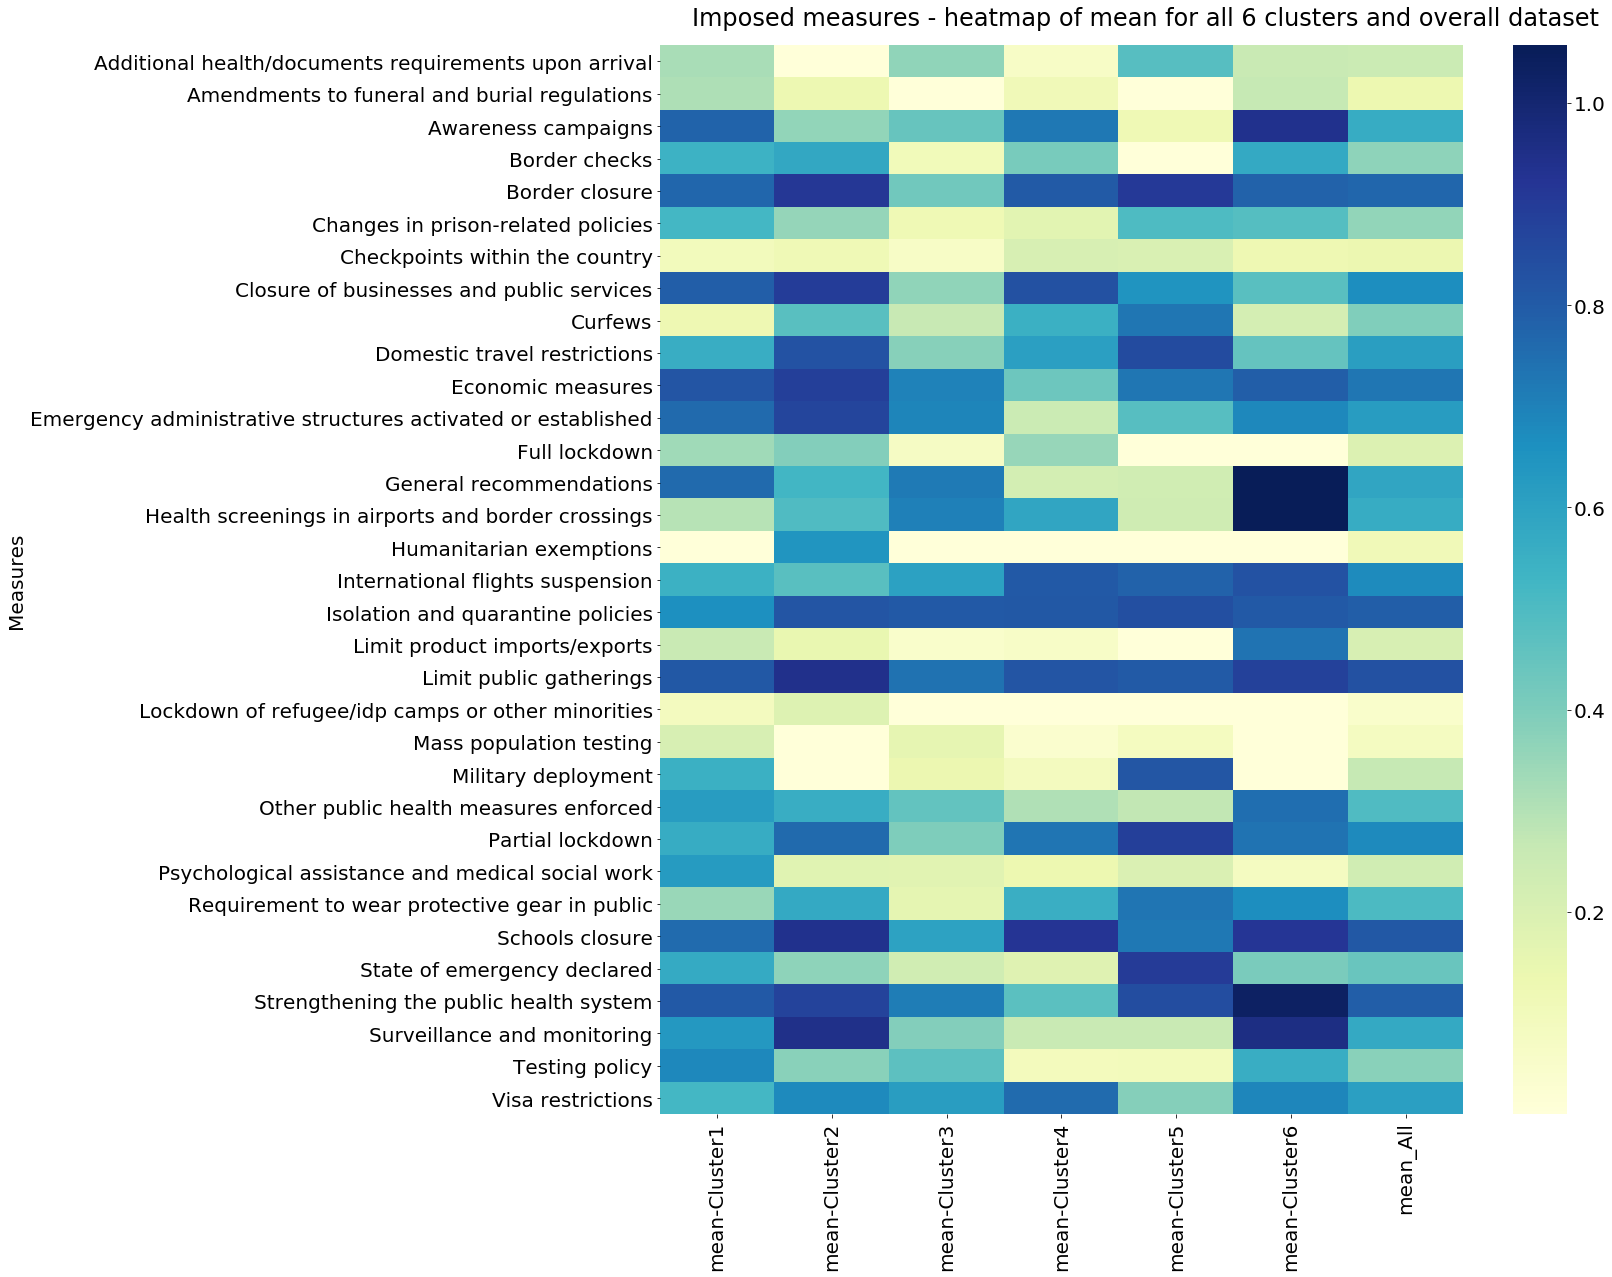

In [37]:
# Create a heatmap containing the means and std of measure variables pertaining to different clusters
heatmap_data = pd.pivot_table(result_df, index=['Measures'])

fig = plt.figure(figsize=(18,18))
plt.rcParams['font.size'] = 20
bg_color = (0.88,0.85,0.95)
hm=sb.heatmap(heatmap_data, cmap="YlGnBu", annot_kws={'size':16}, annot=False)
fig.suptitle('Imposed measures - heatmap of mean for all 6 clusters and overall dataset', fontsize=24)
fig.subplots_adjust(top=0.95)
#plt.xticks(rotation=-15)
figure = hm.get_figure()   
figure.savefig('C:/Users/das_g/Desktop/Gitua/COVID-19/measures_heatmap.jpg', bbox_inches='tight')